# setup

In [1]:
import os
import torch
import time
import numpy as np
import pandas as pd
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [3]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    print("GPU detected. Installing the CUDA-enabled JAX ...")
    device_backend = "gpu"
    !pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
else:
    print("No GPU detected. Installing the CPU-only JAX ...")
    device_backend = "cpu"
    !pip install --upgrade "jax[cpu]"
import jax
print(jax.devices())

No GPU detected. Installing the CPU-only JAX ...
[CpuDevice(id=0)]


In [4]:
# Install the PyTorch version of the timesfm library
!pip install --upgrade timesfm[torch]
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0].


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

path = '/content/drive/MyDrive/dev/'

Mounted at /content/drive/


In [7]:
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

In [8]:
if torch.cuda.is_available():
    !nvcc --version

In [9]:
if torch.cuda.is_available():
    !nvidia-smi

# data

In [10]:
# Load World M2 (wm2) and Bitcoin (btc) data
data_path = path+"sapheneia/github/sapheneia/data/"
btc  = pd.read_csv(data_path+"btc.csv")
wm2 = pd.read_csv(data_path+"wm2.csv")

In [11]:
# Define the horizon for computation of log returns in each time-series
# Given the use case of BTC and WM2 and that WM2 is given in weeks, the number of periods for horizon will be in weeks
logreturn_horizon = 1

In [12]:
# Convert 'Date' column in btc to datetime objects
btc['Date'] = pd.to_datetime(btc['Date'])

# Convert 'observation_date' column in wm2 to datetime objects
wm2['observation_date'] = pd.to_datetime(wm2['observation_date'])

# Merge the two dataframes on the date columns
data = pd.merge(btc, wm2, left_on='Date', right_on='observation_date', how='inner')
data = data[['Date','Close','WM2NS']]
data = data.rename(columns={'Date': 'date','Close': 'btc','WM2NS': 'wm2'})

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2
0,2014-04-21,495.16,11355.4
1,2014-04-28,441.92,11231.2
2,2014-05-05,430.87,11285.3
3,2014-05-12,438.21,11286.0
4,2014-05-19,443.90,11278.4


In [13]:
# prompt: Using dataframe data: Compute a column for each btc and wm2 with the changes from one period to another. Change here is defined as log(x_2,x_1) where x_2 is the value of the column in a period ahead of the value x_1, where the number of periods between x_2 and x_1 is defined by a parameter horizon. Start with the first x_1 as the first period in the dataframe.

# Calculate the log change for 'btc'
data['btc_logreturn'] = np.log(data['btc'] / data['btc'].shift(logreturn_horizon))

# Calculate the log change for 'wm2'
data['wm2_logreturn'] = np.log(data['wm2'] / data['wm2'].shift(logreturn_horizon))

# prompt: Using dataframe data: Now given btc_change and wm2_change, first clean up rows NaN.

# Clean up rows with NaN values in 'btc_change' or 'wm2_change'
data.dropna(subset=['btc_logreturn', 'wm2_logreturn'], inplace=True)

# Round btc_change and wm2_change to 4 decimal places
data['btc_logreturn'] = data['btc_logreturn'].round(4)
data['wm2_logreturn'] = data['wm2_logreturn'].round(4)

# Sort by date to ensure calculations are in chronological order
data.sort_values(by='date', inplace=True)

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2,btc_logreturn,wm2_logreturn
1,2014-04-28,441.92,11231.2,-0.1138,-0.0110
2,2014-05-05,430.87,11285.3,-0.0253,0.0048
3,2014-05-12,438.21,11286.0,0.0169,0.0001
4,2014-05-19,443.90,11278.4,0.0129,-0.0007
5,2014-05-26,582.01,11251.3,0.2709,-0.0024


In [14]:
series_a = data['wm2'].tolist()
print(series_a)

[11231.2, 11285.3, 11286.0, 11278.4, 11251.3, 11345.1, 11363.4, 11380.3, 11290.0, 11343.1, 11426.4, 11423.3, 11393.9, 11364.3, 11461.6, 11431.4, 11442.5, 11383.5, 11442.4, 11495.9, 11516.0, 11436.8, 11451.4, 11556.2, 11556.7, 11570.3, 11525.4, 11574.6, 11621.4, 11643.2, 11580.5, 11668.9, 11725.5, 11765.8, 11784.7, 11799.9, 11830.1, 11807.0, 11762.9, 11687.2, 11788.6, 11822.0, 11864.8, 11850.4, 11927.6, 11956.1, 11988.2, 11933.3, 11970.5, 12122.2, 12100.8, 12043.8, 11862.5, 11907.6, 11914.4, 11928.6, 11882.7, 11941.8, 11980.2, 11996.0, 11940.3, 11958.2, 12091.4, 12045.8, 12010.7, 11960.7, 12045.2, 12073.7, 12107.6, 12051.8, 12087.0, 12170.8, 12196.8, 12142.7, 12084.0, 12180.8, 12170.7, 12177.6, 12143.2, 12260.4, 12303.0, 12334.7, 12281.7, 12316.0, 12380.4, 12417.7, 12472.4, 12464.1, 12496.9, 12552.2, 12508.6, 12423.3, 12466.0, 12478.4, 12545.5, 12532.0, 12559.9, 12658.1, 12681.9, 12684.6, 12735.0, 12825.3, 12839.9, 12850.9, 12693.8, 12710.3, 12731.5, 12748.3, 12701.8, 12689.6, 12802.7, 

In [15]:
series_b = data['btc'].tolist()
print(series_b)

[441.92, 430.87, 438.21, 443.9, 582.01, 655.49, 644.35, 599.08, 591.17, 635.14, 613.6, 618.32, 625.13, 587.93, 592.77, 575.89, 462.18, 502.93, 477.19, 475.69, 477.71, 404.09, 376.77, 331.55, 387.32, 380.39, 350.09, 324.24, 367.15, 384.69, 378.85, 378.61, 364.95, 345.37, 330.84, 314.12, 274.84, 269.33, 215.87, 269.18, 238.86, 220.34, 235.83, 238.82, 273.75, 290.02, 290.41, 265.46, 246.79, 254.97, 223.59, 224.24, 228.96, 238.97, 241.81, 232.64, 237.41, 223.14, 228.57, 237.0, 247.46, 256.97, 269.08, 290.35, 277.68, 293.01, 281.58, 263.3, 257.13, 211.43, 229.47, 239.58, 229.91, 226.33, 238.87, 240.15, 245.35, 263.82, 285.15, 359.28, 380.22, 330.21, 322.12, 377.97, 394.28, 442.0, 437.59, 421.76, 433.32, 447.72, 384.4, 392.76, 372.18, 372.63, 401.07, 437.79, 436.21, 414.87, 414.31, 411.11, 422.21, 419.33, 421.43, 427.69, 461.73, 444.18, 460.44, 454.87, 443.69, 532.26, 583.58, 700.07, 733.97, 644.66, 675.16, 646.71, 670.38, 654.0, 607.0, 589.24, 566.95, 587.47, 574.23, 605.76, 607.98, 609.85,

In [16]:
len(data)

576

# model

In [17]:
# Define parameters for the synthetic data
# CONTEXT_LEN = 512
# HORIZON_LEN = 128
CONTEXT = 64
HORIZON = 20

In [18]:
# Load model from local drive
model_path = path+'.models/google-timesfm-2.0-500m-pytorch/'

# Load model from HuggingFace
#model_path = ''

if model_path=='':
    checkpoint = timesfm.TimesFmCheckpoint(huggingface_repo_id="google/timesfm-2.0-500m-pytorch")
else:
    model_file = os.path.join(model_path, 'torch_model.ckpt')
    checkpoint = timesfm.TimesFmCheckpoint(path=model_file)
checkpoint

TimesFmCheckpoint(version='jax', path='/content/drive/MyDrive/dev/.models/google-timesfm-2.0-500m-pytorch/torch_model.ckpt', huggingface_repo_id=None, type=None, step=None, local_dir=None)

In [19]:
# Initialize the TimesFm model
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend=device_backend,  # Use "gpu" if a GPU runtime is selected
        context_len=CONTEXT,
        horizon_len=HORIZON,
        # The following parameters are fixed for the 2.0-500m model
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False,
    ),
    checkpoint=checkpoint,
)

# experiments

## (1) basic with synthetic data (sine + noise)

In [30]:
# Create a synthetic time-series: a sine wave with noise
# context_data = np.sin(np.linspace(0, 40, CONTEXT_LEN)) + np.random.randn(CONTEXT_LEN) * 0.1
time = np.arange(CONTEXT_LEN)
context_data = np.sin(time * 0.1) + np.sin(time * 0.25) + np.random.randn(len(time)) * 0.5

# The input for the forecast function must be a list of numpy arrays
forecast_input = [context_data]

In [31]:
# Run the forecast
# The `freq` input is a list of integers corresponding to the input series.
# 0 = high frequency (e.g., daily), 1 = medium (e.g., weekly), 2 = low (e.g., yearly)
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=[0],
)

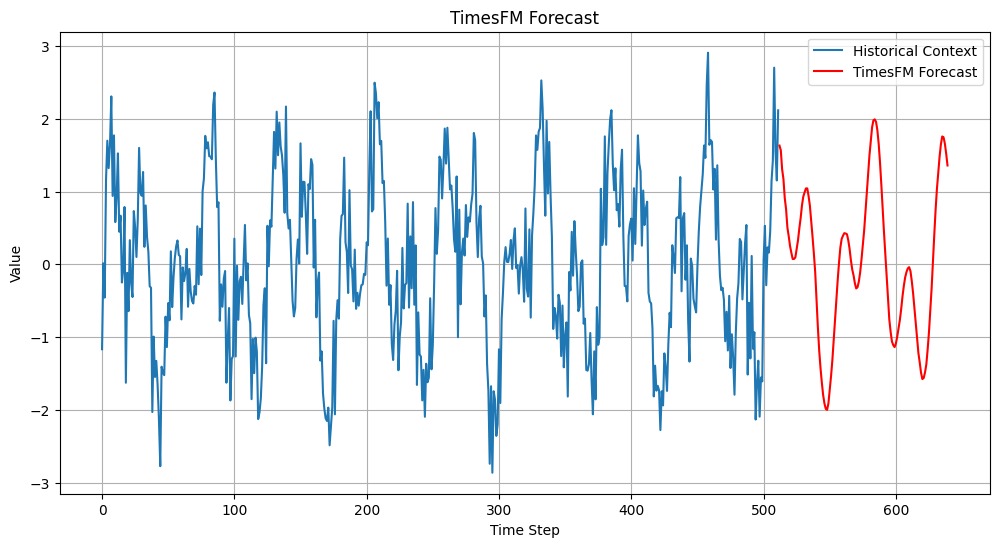

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assume CONTEXT_LEN and HORIZON_LEN are defined in your environment
# Assume context_data and point_forecast already exist from your previous steps

plt.figure(figsize=(12, 6))

# Plot the historical data that the model used as input
plt.plot(np.arange(CONTEXT_LEN), context_data, label="Historical Context")

# Plot the forecasted data
# The forecast starts at the end of the context
forecast_horizon = np.arange(CONTEXT_LEN, CONTEXT_LEN + HORIZON_LEN)

# By using point_forecast[0], we select the 1D array from the 2D batch, fixing the error.
plt.plot(forecast_horizon, point_forecast[0], color='red', label="TimesFM Forecast")

# --- Formatting ---
plt.title("TimesFM Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
experimental_quantile_forecast, experimental_quantile_forecast.shape

(array([[[1.6372994 , 0.97508764, 1.2086987 , ..., 1.8921614 ,
          2.0586965 , 2.2899003 ],
         [1.563626  , 0.91982067, 1.1454911 , ..., 1.8298789 ,
          1.9912821 , 2.2194676 ],
         [1.2992289 , 0.6749248 , 0.9049376 , ..., 1.5630562 ,
          1.72939   , 1.9533336 ],
         ...,
         [1.6579363 , 1.0440068 , 1.252825  , ..., 1.9105881 ,
          2.061696  , 2.2735317 ],
         [1.521943  , 0.929659  , 1.124909  , ..., 1.7821602 ,
          1.9227628 , 2.134675  ],
         [1.3501425 , 0.75629103, 0.96000123, ..., 1.6085737 ,
          1.7618796 , 1.972828  ]]], dtype=float32),
 (1, 128, 10))

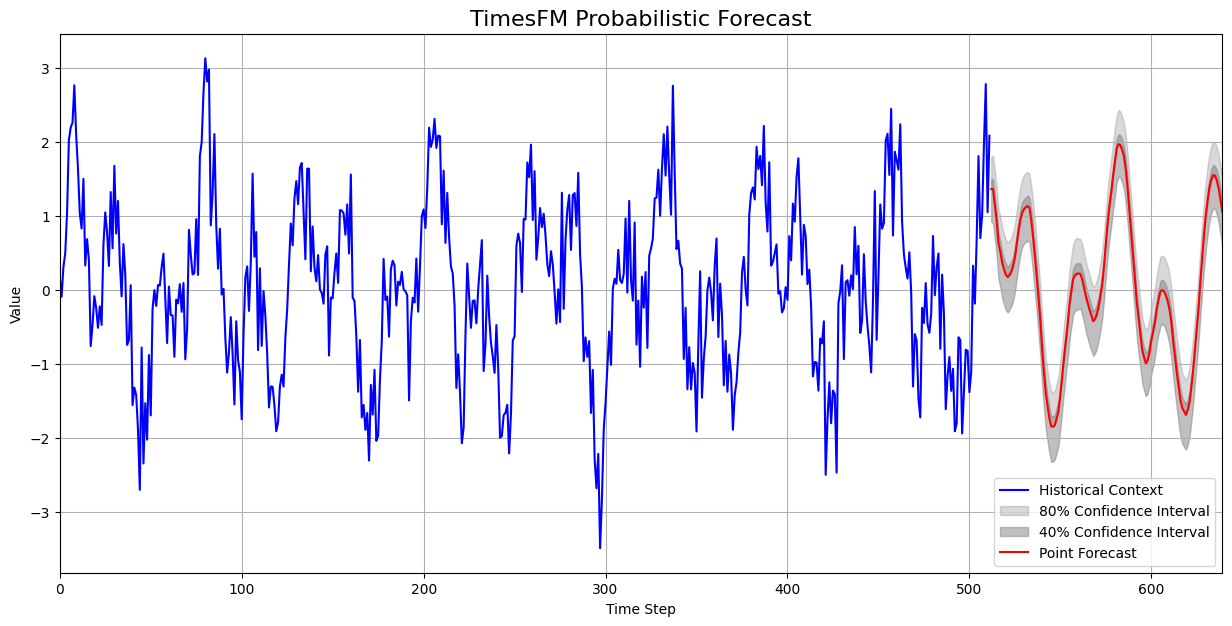

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assume CONTEXT_LEN and HORIZON_LEN are defined in your environment
# Assume context_data, point_forecast, and experimental_quantile_forecast already exist

plt.figure(figsize=(15, 7))

# 1. Plot the historical data that the model used as input
plt.plot(np.arange(CONTEXT_LEN), context_data, 'b-', label="Historical Context")

# Define the x-axis for the forecast period
forecast_horizon = np.arange(CONTEXT_LEN, CONTEXT_LEN + HORIZON_LEN)

# 2. Extract and plot the quantile forecasts to create the "cloud"
# First, get the forecast batch (index 0) from the quantile data
quantile_forecasts_1d = experimental_quantile_forecast[0]

# Plot the 80% confidence interval (between 0.1 and 0.9 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 0], # 0.1 quantile at index 0
    quantile_forecasts_1d[:, 8], # 0.9 quantile at index 8
    color='gray',
    alpha=0.3,
    label='80% Confidence Interval'
)

# Plot the 40% confidence interval (between 0.3 and 0.7 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 2], # 0.3 quantile at index 2
    quantile_forecasts_1d[:, 6], # 0.7 quantile at index 6
    color='gray',
    alpha=0.5,
    label='40% Confidence Interval'
)

# 3. Plot the main point forecast
# We use point_forecast[0] to select the 1D array from the 2D batch
plt.plot(forecast_horizon, point_forecast[0], 'r-', label="Point Forecast")


# --- Formatting ---
plt.title("TimesFM Probabilistic Forecast", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.show()

## (2) btc, normalized log-returns, no covariate

### code

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [20]:
def inverse_sigmoid(y):
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [21]:
def fit_normalizer(data):

    data_reshaped = data.reshape(-1, 1)

    # Fit a StandardScaler to the raw data
    normalizer = StandardScaler()
    normalizer.fit(data_reshaped)

    return normalizer

In [22]:
def normalize_data(data, normalizer, sigmoid=False):

    data_reshaped = data.reshape(-1, 1)

    # Standardize the data (mean=0, std=1)
    x = normalizer.transform(data_reshaped)

    if sigmoid:
        x = sigmoid(x).flatten()

    return x.reshape(-1)

In [66]:
def denormalize_data(data, normalizer, sigmoid=False):

    if sigmoid:
        x = inverse_sigmoid(data)
    else:
        x = data

    return normalizer.inverse_transform(x.reshape(1, -1)).reshape(-1)

In [24]:
def compute_logreturns(data, lookback=1):

    logdata = np.log(data)

    return logdata[lookback:] - logdata[:-lookback]

In [25]:
def reverse_logreturns(initial, logreturns):

    return np.exp(np.cumsum(logreturns))*initial

### experiment

In [26]:
lookback = 1

In [27]:
context = data['btc'][-(lookback+CONTEXT):].to_numpy()
horizon = context[-HORIZON:]
context,horizon

(array([ 49942.969,  51781.219,  54518.578,  68338.641,  72095.859,
         67609.438,  69892.258,  69686.367,  71629.359,  63447.27 ,
         66854.242,  63847.539,  63168.441,  62932.289,  71430.227,
         69386.828,  68799.602,  69505.57 ,  66481.727,  60270.949,
         62841.27 ,  56709.762,  64765.551,  67567.711,  66782.781,
         54031.82 ,  59360.891,  59464.41 ,  62850.27 ,  59147.801,
         57056.309,  58210.012,  63341.969,  63314.809,  62209.84 ,
         66068.25 ,  67358.141,  69925.828,  67811.953,  88758.313,
         90514.828,  93019.383,  95859.75 ,  97338.344, 106089.203,
         94771.641,  92646.211, 102282.203,  94517.656, 102148.742,
        102065.719, 101451.281,  97458.594,  95790.313,  91536.969,
         86158.953,  78561.617,  84025.117,  87520.477,  82539.523,
         79143.063,  84575.75 ,  87515.57 ,  95035.063,  94767.953]),
 array([ 94771.641,  92646.211, 102282.203,  94517.656, 102148.742,
        102065.719, 101451.281,  97458.594,  9

In [28]:
x_log = compute_logreturns(context[:-HORIZON], lookback=lookback)
x_log

array([ 0.03614578,  0.05151401,  0.22593384,  0.05352125, -0.06424902,
        0.0332073 , -0.00295018,  0.02750033, -0.12129586,  0.05230559,
       -0.04601672, -0.01069321, -0.00374545,  0.12666176, -0.02902408,
       -0.00849909,  0.01020893, -0.04447977, -0.09807691,  0.04176181,
       -0.10266566,  0.13282748,  0.04235638, -0.01168494, -0.21187215,
        0.09406248,  0.00174237,  0.05537725, -0.06071582, -0.03600076,
        0.02001871,  0.08449076, -0.00042888, -0.01760606,  0.06017511,
        0.01933547,  0.03741131, -0.0306966 ,  0.26917861,  0.01959659,
        0.02729421,  0.03007829,  0.01530681,  0.08608729])

In [42]:
normalizer = fit_normalizer(x_log)
normalizer.mean_, normalizer.scale_

(array([0.01712269]), array([0.08108505]))

In [30]:
z_log = normalize_data(x_log, normalizer, sigmoid=False)
z_log

array([ 0.23460659,  0.42413877,  2.5752113 ,  0.44889351, -1.00353533,
        0.19836704, -0.24755334,  0.12798456, -1.70707862,  0.43390113,
       -0.77868129, -0.34304606, -0.25736123,  1.35091561, -0.56911563,
       -0.31598654, -0.08526554, -0.75972646, -1.4207256 ,  0.30386755,
       -1.47731733,  1.42695576,  0.31120021, -0.35527679, -2.82413138,
        0.94887751, -0.18968133,  0.47178307, -0.9599613 , -0.65515713,
        0.03571578,  0.83083212, -0.21645876, -0.42830038,  0.53095382,
        0.0272896 ,  0.25021399, -0.58974245,  3.10853744,  0.0305099 ,
        0.12544253,  0.15977792, -0.02239486,  0.85052165])

In [55]:
# Run the forecast
# The `freq` input is a list of integers corresponding to the input series.
# 0 = high frequency (e.g., daily), 1 = medium (e.g., weekly), 2 = low (e.g., yearly)
forecast_input = [z_log]
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=[1],
)
point_forecast[0]

array([ 0.14061469,  0.17454681,  0.1346572 ,  0.06237289,  0.00478315,
        0.11414178,  0.13430518,  0.07794426, -0.01328939,  0.00554471,
        0.01955744,  0.0079724 , -0.07553854, -0.03223418, -0.04871809,
       -0.10693178, -0.14782518, -0.07745541, -0.03169262, -0.12427748],
      dtype=float32)

In [67]:
f_log = denormalize_data(data=point_forecast[0], normalizer=normalizer)
f_log

array([0.02852444, 0.03127583, 0.02804138, 0.0221802 , 0.01751054,
       0.02637789, 0.02801284, 0.02344281, 0.01604512, 0.01757229,
       0.01870851, 0.01776914, 0.01099765, 0.01450898, 0.01317239,
       0.00845212, 0.00513628, 0.01084222, 0.0145529 , 0.00704565],
      dtype=float32)

In [68]:
forecast = reverse_logreturns(initial=context[CONTEXT-HORIZON], logreturns=f_log)
forecast,len(forecast)

(array([109158.91467176, 112626.8999523 , 115829.80791669, 118427.62884906,
        120519.62762796, 123740.98730057, 127256.33491647, 130274.8143264 ,
        132381.95134707, 134728.75822548, 137273.05782188, 139734.09076515,
        141279.31699221, 143344.07452402, 145244.75223237, 146477.5893952 ,
        147231.87094529, 148836.86603667, 151018.69516751, 152086.50399549]),
 20)

In [71]:
n = len(experimental_quantile_forecast[0])
quantiles = []
for q_forecast in experimental_quantile_forecast[0]:
    q_log = denormalize_data(data=q_forecast, normalizer=normalizer)
    q = reverse_logreturns(initial=context[CONTEXT-HORIZON], logreturns=q_log)
    quantiles.append(q)
quantiles = np.array(quantiles)

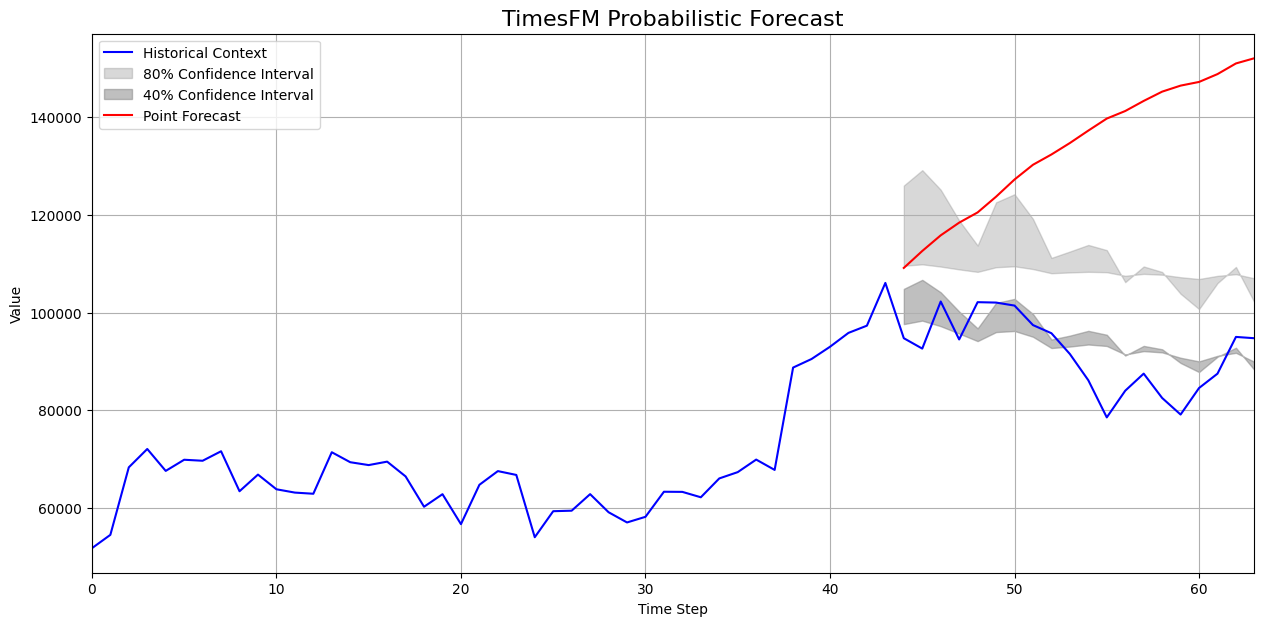

In [72]:

plt.figure(figsize=(15, 7))

# 1. Plot the historical data that the model used as input
plt.plot(np.arange(CONTEXT), context[1:], 'b-', label="Historical Context")

# Define the x-axis for the forecast period
forecast_horizon = np.arange(CONTEXT-HORIZON, CONTEXT)

# 2. Extract and plot the quantile forecasts to create the "cloud"
# First, get the forecast batch (index 0) from the quantile data
quantile_forecasts_1d = quantiles

# Plot the 80% confidence interval (between 0.1 and 0.9 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 0], # 0.1 quantile at index 0
    quantile_forecasts_1d[:, 8], # 0.9 quantile at index 8
    color='gray',
    alpha=0.3,
    label='80% Confidence Interval'
)

# Plot the 40% confidence interval (between 0.3 and 0.7 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 2], # 0.3 quantile at index 2
    quantile_forecasts_1d[:, 6], # 0.7 quantile at index 6
    color='gray',
    alpha=0.5,
    label='40% Confidence Interval'
)

# 3. Plot the main point forecast
# We use point_forecast[0] to select the 1D array from the 2D batch
plt.plot(forecast_horizon, forecast, 'r-', label="Point Forecast")


# --- Formatting ---
plt.title("TimesFM Probabilistic Forecast", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.show()

## (2) btc, no normalization or log-returns, no covariate

### experiment

In [ ]:
lookback = 1

In [82]:
context = data['btc'][-(lookback+CONTEXT):].to_numpy()
horizon = context[-HORIZON:]
context,context[:-HORIZON],horizon

(array([ 49942.969,  51781.219,  54518.578,  68338.641,  72095.859,
         67609.438,  69892.258,  69686.367,  71629.359,  63447.27 ,
         66854.242,  63847.539,  63168.441,  62932.289,  71430.227,
         69386.828,  68799.602,  69505.57 ,  66481.727,  60270.949,
         62841.27 ,  56709.762,  64765.551,  67567.711,  66782.781,
         54031.82 ,  59360.891,  59464.41 ,  62850.27 ,  59147.801,
         57056.309,  58210.012,  63341.969,  63314.809,  62209.84 ,
         66068.25 ,  67358.141,  69925.828,  67811.953,  88758.313,
         90514.828,  93019.383,  95859.75 ,  97338.344, 106089.203,
         94771.641,  92646.211, 102282.203,  94517.656, 102148.742,
        102065.719, 101451.281,  97458.594,  95790.313,  91536.969,
         86158.953,  78561.617,  84025.117,  87520.477,  82539.523,
         79143.063,  84575.75 ,  87515.57 ,  95035.063,  94767.953]),
 array([ 49942.969,  51781.219,  54518.578,  68338.641,  72095.859,
         67609.438,  69892.258,  69686.367,  7

In [83]:
# Run the forecast
# The `freq` input is a list of integers corresponding to the input series.
# 0 = high frequency (e.g., daily), 1 = medium (e.g., weekly), 2 = low (e.g., yearly)
forecast_input = [context[:-HORIZON]]
point_forecast, experimental_quantile_forecast = tfm.forecast(
    forecast_input,
    freq=[1],
)
point_forecast[0]

array([100619.39 ,  99136.14 ,  99420.5  ,  98836.91 ,  97539.25 ,
        97742.375,  98700.01 ,  98864.78 ,  97359.22 ,  96897.83 ,
        96303.875,  96556.73 ,  95967.125,  95084.44 ,  95260.35 ,
        94504.41 ,  93950.22 ,  94009.64 ,  94616.81 ,  94713.31 ],
      dtype=float32)

In [86]:
forecast = point_forecast[0]
quantiles = experimental_quantile_forecast[0]

In [98]:
forecast_horizon,np.arange(CONTEXT-HORIZON-1, CONTEXT),context[:-HORIZON][-1],context[-HORIZON-1],CONTEXT-HORIZON-1

(array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63]),
 array([43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63]),
 np.float64(106089.203),
 np.float64(106089.203),
 43)

In [89]:
np.arange(CONTEXT)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

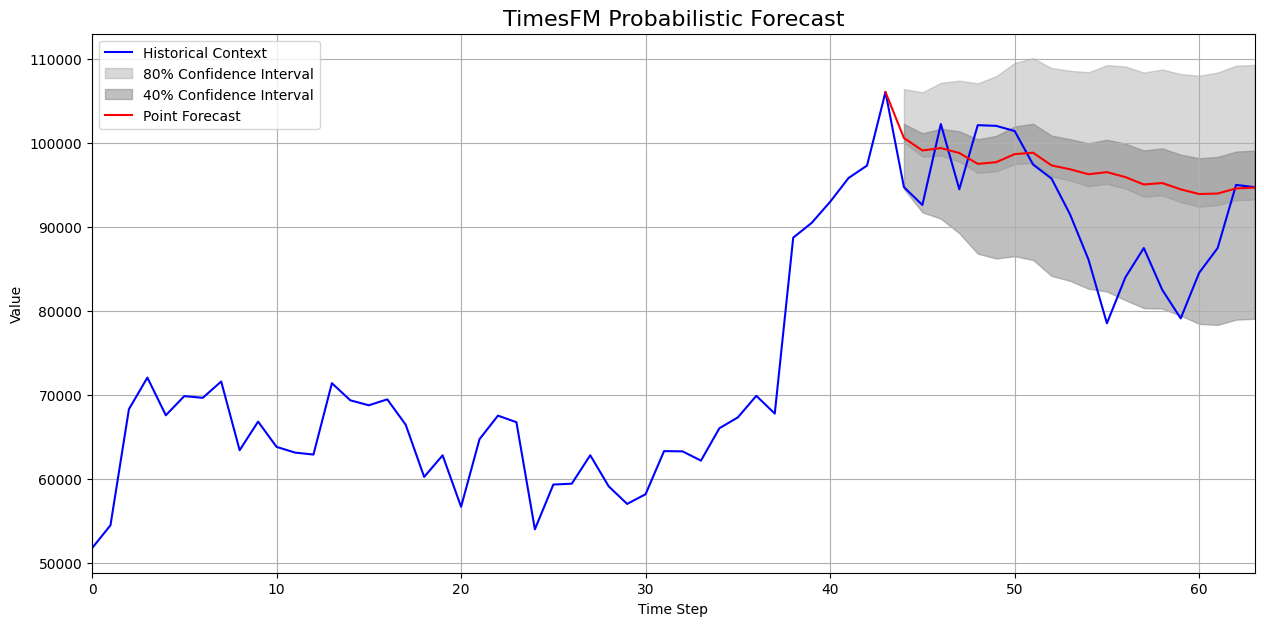

In [99]:
plt.figure(figsize=(15, 7))

# 1. Plot the historical data that the model used as input
plt.plot(np.arange(CONTEXT), context[1:], 'b-', label="Historical Context")

# Define the x-axis for the forecast period
forecast_horizon = np.arange(CONTEXT-HORIZON, CONTEXT)

# 2. Extract and plot the quantile forecasts to create the "cloud"
# First, get the forecast batch (index 0) from the quantile data
quantile_forecasts_1d = quantiles

# Plot the 80% confidence interval (between 0.1 and 0.9 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 0], # 0.1 quantile at index 0
    quantile_forecasts_1d[:, 8], # 0.9 quantile at index 8
    color='gray',
    alpha=0.3,
    label='80% Confidence Interval'
)

# Plot the 40% confidence interval (between 0.3 and 0.7 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 2], # 0.3 quantile at index 2
    quantile_forecasts_1d[:, 6], # 0.7 quantile at index 6
    color='gray',
    alpha=0.5,
    label='40% Confidence Interval'
)

# 3. Plot the main point forecast
# We use point_forecast[0] to select the 1D array from the 2D batch
x = [CONTEXT-HORIZON-1]+forecast_horizon.tolist()
y = [context[:-HORIZON][-1]]+forecast.tolist()

plt.plot(x, y, 'r-', label="Point Forecast")

# --- Formatting ---
plt.title("TimesFM Probabilistic Forecast", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.show()

## (3) btc with wm2 covariate

### code

### experiment

In [ ]:
from timesfm import TimesFm

# Define your model's context and horizon lengths
model_context_len = 512
model_horizon_len = 64
num_covariates = 1 # We are using one covariate

# Isolate the input data
prediction_input_df = df.iloc[-model_context_len:]

# 1. Create the target series context
# Shape must be (batch_size, context_len) -> (1, 512)
context_ts = prediction_input_df['btc_price'].values.reshape(1, -1)

# 2. Create the covariate context
# Shape must be (batch_size, context_len, num_covariates) -> (1, 512, 1)
context_covariates = prediction_input_df['wm2'].values.reshape(1, model_context_len, num_covariates)

# 3. Create placeholder for future covariates
# Shape must be (batch_size, horizon_len, num_covariates) -> (1, 64, 1)
future_covariates = np.zeros((1, model_horizon_len, num_covariates))

# Load the model, making sure to specify num_covariates
tfm = TimesFm(
    context_len=model_context_len,
    horizon_len=model_horizon_len,
    num_covariates=num_covariates, # Crucial step!
    # ... other parameters
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Run the forecast using the specific method for covariates
point_forecasts, _ = tfm.forecast_with_covariates(
    context_ts,
    context_covariates,
    future_covariates,
)

In [102]:
num_covariates = 1

In [146]:
btc_context = data['btc'][-(CONTEXT+HORIZON):-HORIZON].values.reshape(1, -1)
btc_future = data['btc'][-HORIZON:].values.reshape(1, -1)
btc_context,btc_future

(array([[ 27507.221,  27598.77 ,  28518.369,  33084.078,  34494.559,
          35054.59 ,  36482.512,  37476.66 ,  37246.289,  41984.41 ,
          41235.578,  42650.27 ,  43628.   ,  44197.609,  46988.141,
          42491.262,  39523.629,  43302.281,  42664.559,  49942.969,
          51781.219,  54518.578,  68338.641,  72095.859,  67609.438,
          69892.258,  69686.367,  71629.359,  63447.27 ,  66854.242,
          63847.539,  63168.441,  62932.289,  71430.227,  69386.828,
          68799.602,  69505.57 ,  66481.727,  60270.949,  62841.27 ,
          56709.762,  64765.551,  67567.711,  66782.781,  54031.82 ,
          59360.891,  59464.41 ,  62850.27 ,  59147.801,  57056.309,
          58210.012,  63341.969,  63314.809,  62209.84 ,  66068.25 ,
          67358.141,  69925.828,  67811.953,  88758.313,  90514.828,
          93019.383,  95859.75 ,  97338.344, 106089.203]]),
 array([[ 94771.641,  92646.211, 102282.203,  94517.656, 102148.742,
         102065.719, 101451.281,  97458.594

In [162]:
wm2_context = data['wm2'][-(CONTEXT+HORIZON):-HORIZON].values.reshape(1, CONTEXT, num_covariates)
wm2_future = np.zeros((1, HORIZON, num_covariates))
# wm2_future = data['wm2'][-HORIZON:].values.reshape(1, HORIZON, num_covariates)
wm2 = np.concatenate([wm2_context, wm2_future], axis=1)
# wm2_context,wm2_future

In [163]:
btc_context = btc_context.astype('float32')
wm2_context = wm2_context.astype('float32')
wm2_future = wm2_future.astype('float32')
wm2 = wm2.astype('float32')

In [164]:
covariate = {
    'wm2_covariate': wm2_context.reshape(1, -1).tolist()
}

In [165]:
# The `freq` input is a list of integers corresponding to the input series.
# 0 = high frequency (e.g., daily), 1 = medium (e.g., weekly), 2 = low (e.g., yearly)
point_forecast, experimental_quantile_forecast = tfm.forecast_with_covariates(
    inputs=btc_context,
    dynamic_numerical_covariates=covariate,
    freq=[1],
)

ValueError: math domain error

In [151]:
forecast = point_forecast[0]
forecast

array([-1193309.88209776, -1194792.6377864 , -1195642.35262751,
       -1196314.88448238, -1197098.51770455, -1197468.41680657,
       -1197950.33873271, -1198269.55770865, -1198705.40679291,
       -1198928.00443758, -1199241.5630358 , -1199788.90839743,
       -1200202.3792442 , -1200491.45341787, -1200891.89223222,
       -1201315.10419414, -1201601.15072392, -1201559.29025614,
       -1201961.57198417, -1201969.47018564])

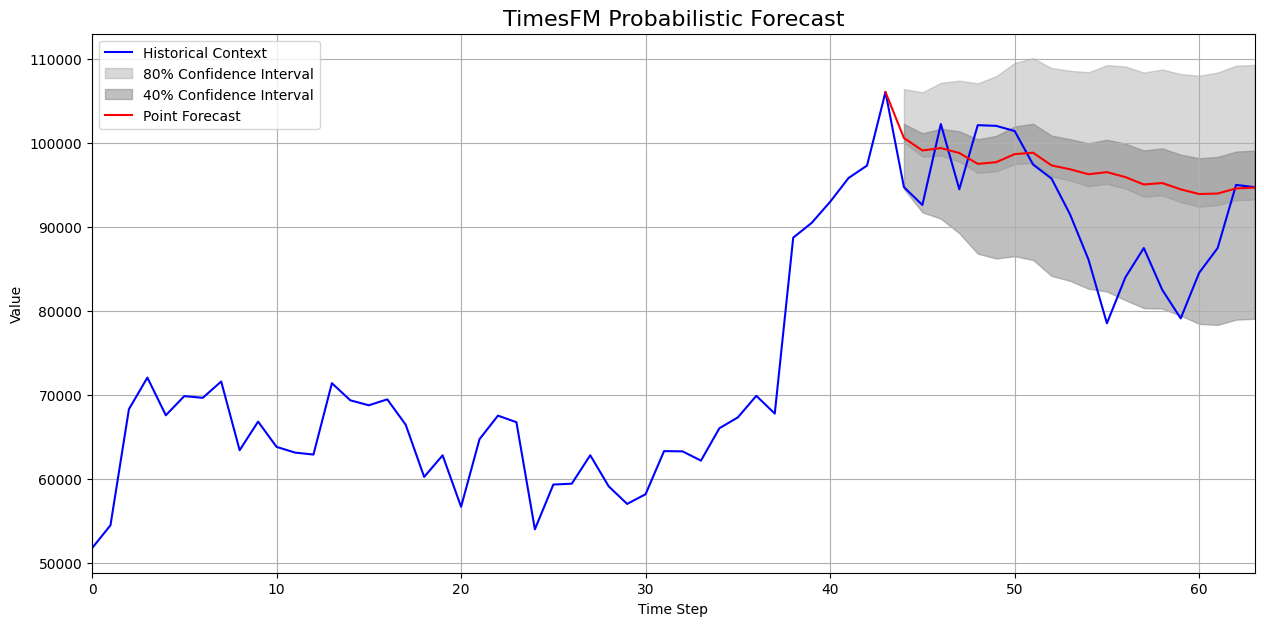

In [ ]:
plt.figure(figsize=(15, 7))

# 1. Plot the historical data that the model used as input
plt.plot(np.arange(CONTEXT), context[1:], 'b-', label="Historical Context")

# Define the x-axis for the forecast period
forecast_horizon = np.arange(CONTEXT-HORIZON, CONTEXT)

# 2. Extract and plot the quantile forecasts to create the "cloud"
# First, get the forecast batch (index 0) from the quantile data
quantile_forecasts_1d = quantiles

# Plot the 80% confidence interval (between 0.1 and 0.9 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 0], # 0.1 quantile at index 0
    quantile_forecasts_1d[:, 8], # 0.9 quantile at index 8
    color='gray',
    alpha=0.3,
    label='80% Confidence Interval'
)

# Plot the 40% confidence interval (between 0.3 and 0.7 quantiles)
plt.fill_between(
    forecast_horizon,
    quantile_forecasts_1d[:, 2], # 0.3 quantile at index 2
    quantile_forecasts_1d[:, 6], # 0.7 quantile at index 6
    color='gray',
    alpha=0.5,
    label='40% Confidence Interval'
)

# 3. Plot the main point forecast
# We use point_forecast[0] to select the 1D array from the 2D batch
x = [CONTEXT-HORIZON-1]+forecast_horizon.tolist()
y = [context[:-HORIZON][-1]]+forecast.tolist()

plt.plot(x, y, 'r-', label="Point Forecast")

# --- Formatting ---
plt.title("TimesFM Probabilistic Forecast", fontsize=16)
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.show()

## test code

In [119]:
lookback = 1
window = 50
horizon = 10

In [120]:
x = data['btc'][-(lookback+window):].to_numpy()
x_log = compute_logreturns(x, lookback=lookback)
x_log

array([-0.02902408, -0.00849909,  0.01020893, -0.04447977, -0.09807691,
        0.04176181, -0.10266566,  0.13282748,  0.04235638, -0.01168494,
       -0.21187215,  0.09406248,  0.00174237,  0.05537725, -0.06071582,
       -0.03600076,  0.02001871,  0.08449076, -0.00042888, -0.01760606,
        0.06017511,  0.01933547,  0.03741131, -0.0306966 ,  0.26917861,
        0.01959659,  0.02729421,  0.03007829,  0.01530681,  0.08608729,
       -0.11281006, -0.02268216,  0.09894763, -0.07894904,  0.07764335,
       -0.0008131 , -0.00603822, -0.04015108, -0.01726605, -0.04541864,
       -0.06054904, -0.09231063,  0.06723252,  0.04075702, -0.05859554,
       -0.04202011,  0.06639044,  0.03416914,  0.08242919, -0.0028146 ])

In [121]:
y_log = x_log[:-horizon]
normalizer = fit_normalizer(y_log)

In [122]:
x_log,y_log

(array([-0.02902408, -0.00849909,  0.01020893, -0.04447977, -0.09807691,
         0.04176181, -0.10266566,  0.13282748,  0.04235638, -0.01168494,
        -0.21187215,  0.09406248,  0.00174237,  0.05537725, -0.06071582,
        -0.03600076,  0.02001871,  0.08449076, -0.00042888, -0.01760606,
         0.06017511,  0.01933547,  0.03741131, -0.0306966 ,  0.26917861,
         0.01959659,  0.02729421,  0.03007829,  0.01530681,  0.08608729,
        -0.11281006, -0.02268216,  0.09894763, -0.07894904,  0.07764335,
        -0.0008131 , -0.00603822, -0.04015108, -0.01726605, -0.04541864,
        -0.06054904, -0.09231063,  0.06723252,  0.04075702, -0.05859554,
        -0.04202011,  0.06639044,  0.03416914,  0.08242919, -0.0028146 ]),
 array([-0.02902408, -0.00849909,  0.01020893, -0.04447977, -0.09807691,
         0.04176181, -0.10266566,  0.13282748,  0.04235638, -0.01168494,
        -0.21187215,  0.09406248,  0.00174237,  0.05537725, -0.06071582,
        -0.03600076,  0.02001871,  0.08449076, -0

In [123]:
z_log = normalize_data(y_log, normalizer, sigmoid=False)
z_log

array([-0.45441513, -0.18963262,  0.0517102 , -0.65380121, -1.34523109,
        0.45875801, -1.40442816,  1.63355039,  0.46642825, -0.23073169,
       -2.81324617,  1.13346262, -0.05751263,  0.63440394, -0.86325436,
       -0.54441777,  0.1782612 ,  1.0099827 , -0.08552282, -0.3071171 ,
        0.69629876,  0.1694471 ,  0.40263438, -0.47599156,  3.39254789,
        0.17281566,  0.27211875,  0.30803485,  0.1174753 ,  1.0305787 ,
       -1.53529598, -0.3726013 ,  1.19648357, -1.09847194,  0.92164776,
       -0.09047946, -0.15788611, -0.59795904, -0.30273072, -0.66591315])

In [131]:
denormalize_data(data=z_log, normalizer=normalizer)

array([-0.02902408, -0.00849909,  0.01020893, -0.04447977, -0.09807691,
        0.04176181, -0.10266566,  0.13282748,  0.04235638, -0.01168494,
       -0.21187215,  0.09406248,  0.00174237,  0.05537725, -0.06071582,
       -0.03600076,  0.02001871,  0.08449076, -0.00042888, -0.01760606,
        0.06017511,  0.01933547,  0.03741131, -0.0306966 ,  0.26917861,
        0.01959659,  0.02729421,  0.03007829,  0.01530681,  0.08608729,
       -0.11281006, -0.02268216,  0.09894763, -0.07894904,  0.07764335,
       -0.0008131 , -0.00603822, -0.04015108, -0.01726605, -0.04541864])

In [65]:
h_log = normalize_data(x_log[-horizon:], normalizer, sigmoid=False)
h_log

array([-0.86110288, -1.2708432 ,  0.78734282,  0.44579575, -0.83590177,
       -0.62207039,  0.77647963,  0.36080876,  0.9833874 , -0.11629991])

In [66]:
normalize_data(x_log, normalizer, sigmoid=False)

array([-0.45441513, -0.18963262,  0.0517102 , -0.65380121, -1.34523109,
        0.45875801, -1.40442816,  1.63355039,  0.46642825, -0.23073169,
       -2.81324617,  1.13346262, -0.05751263,  0.63440394, -0.86325436,
       -0.54441777,  0.1782612 ,  1.0099827 , -0.08552282, -0.3071171 ,
        0.69629876,  0.1694471 ,  0.40263438, -0.47599156,  3.39254789,
        0.17281566,  0.27211875,  0.30803485,  0.1174753 ,  1.0305787 ,
       -1.53529598, -0.3726013 ,  1.19648357, -1.09847194,  0.92164776,
       -0.09047946, -0.15788611, -0.59795904, -0.30273072, -0.66591315,
       -0.86110288, -1.2708432 ,  0.78734282,  0.44579575, -0.83590177,
       -0.62207039,  0.77647963,  0.36080876,  0.9833874 , -0.11629991])

In [67]:
#reverse_logreturns(data=x, logreturns=x_log, lookback=lookback)

np.exp(x_log)*x[:-lookback]

array([ 69386.828,  68799.602,  69505.57 ,  66481.727,  60270.949,
        62841.27 ,  56709.762,  64765.551,  67567.711,  66782.781,
        54031.82 ,  59360.891,  59464.41 ,  62850.27 ,  59147.801,
        57056.309,  58210.012,  63341.969,  63314.809,  62209.84 ,
        66068.25 ,  67358.141,  69925.828,  67811.953,  88758.313,
        90514.828,  93019.383,  95859.75 ,  97338.344, 106089.203,
        94771.641,  92646.211, 102282.203,  94517.656, 102148.742,
       102065.719, 101451.281,  97458.594,  95790.313,  91536.969,
        86158.953,  78561.617,  84025.117,  87520.477,  82539.523,
        79143.063,  84575.75 ,  87515.57 ,  95035.063,  94767.953])

In [71]:
reverse_logreturns(data=x, logreturns=x_log, lookback=lookback)

array([ 69386.828,  68799.602,  69505.57 ,  66481.727,  60270.949,
        62841.27 ,  56709.762,  64765.551,  67567.711,  66782.781,
        54031.82 ,  59360.891,  59464.41 ,  62850.27 ,  59147.801,
        57056.309,  58210.012,  63341.969,  63314.809,  62209.84 ,
        66068.25 ,  67358.141,  69925.828,  67811.953,  88758.313,
        90514.828,  93019.383,  95859.75 ,  97338.344, 106089.203,
        94771.641,  92646.211, 102282.203,  94517.656, 102148.742,
       102065.719, 101451.281,  97458.594,  95790.313,  91536.969,
        86158.953,  78561.617,  84025.117,  87520.477,  82539.523,
        79143.063,  84575.75 ,  87515.57 ,  95035.063,  94767.953])